# San Jose Electrification Savings with PG&E Electric Home Rate

## Goal
Model Heat Pump and Heat Pump Water Heater Savings in San Jose under PG&E's Electric Home Rate as part of [this larger Ad Hoc](https://www.notion.so/rewiringamerica/San-Jose-electrification-savings-1fa4c9af1a1c8137938dc02bde9ba456?pvs=4).

## Assumptions
- Universe of households: Single Family, Owner Occupied Homes in San Jose without a heat pump in baseline, according to 2024.2 ResStock
- Upgrades: Medium Efficiency Heat Pump and Heat Pump Water Heater
- Rates:
  - Electricity
    - Pre-Upgrade: PG&E's [E-TOU-C Rate](https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-TOU-C.pdf) which [is the default](https://www.energytoolbase.com/blog/policyupdate/pacific-gas-electric-implements-new-rates/#:~:text=As%20of%20now%2C%20new%20residential,default%20rate%20at%20that%20time.). Assumptions:
      - We assume the baseline allowance for Baseline Territory X [which San Jose False into according to this EXTREMELY OLD map which is hopefully still acccurate](https://www.pge.com/assets/rates/tariffs/PGECZ_90Rev.pdf)
      - We assume the baseline allowance for "Code B - Basic Quantities" allowance even though homes with electric resistance heating would be eligible for the higher winter "Code H - All-Electric Quantities", which means *we are likely overestimating savings estimate for the 20% of electric resistance households, but it is worth noting that this is probably reasonable as a default since the household would likely need to opt into this anyway* (see tariff sheet p4 for details). This caveat also applies for the bonus analysis at the end where we model the heat pump upgrade under this rate. 
      - We found that all (building, days) have high enough usage such that they are above the "Delivery Minimum Bill Amount" (which makes sense since this is primarily meant to deal with vacant homes) so we do not model this. 
    - Post-Upgrade: PG&E's [E-ELEC Rate](https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-ELEC.pdf) which homes with [Heat Pumps or Heat Pump Water Heaters are eligible for](https://www.pge.com/assets/pge/docs/account/rate-plans/electric-home-rate-plan-en.pdf). 
  - Gas :
    - [G1 Residential Service](https://www.pge.com/tariffs/assets/pdf/tariffbook/GAS_SCHEDS_G-1.pdf), which is a tiered block rate (where the threshold for the baseline tier varies by season) with no fixed charge but a minimum delivery charge per day, as well as a gas climate credit from CA's cap and trade program. Some assumptions/limitations of this analysis:
      - We ignore the second "Excess" tier, and assume all gas usage is on the baseline tier, which underestimates gas costs for homes with decent levels of gas usage. This means that are we *underestimating gas savings for gas heated homes by a decent margin*.
      - We assume a fixed procurement cost per month based on the tariff sheet, but in actuality this does vary slightly from month to month, although not enough to make a major difference.
      - We include the [Public Purchase Program Surcharge](https://www.pge.com/tariffs/assets/pdf/tariffbook/GAS_SCHEDS_G-PPPS.pdf) and assume Non-CARE rates, which may result in a slight overestimate of gas bills for low income homes. 
      - We ignore the minimum transportation (non-procurement) charge per day, and there are between 10-25% of days where the bills are below this minimum depending on the upgrade. At the extreme if a home had NO gas usage but still has a gas connection, they would pay an extra 50 dollars/year, so we can think of this as the upper bound of overestimation of savings. However it is worth noting that the gas climate credit is about ~60 dollars/year, and we assume non-negative gas bills so a minimal gas bill would offset by this credit anyway. 
- Delivered Fuels: California 5 year averages from EIA


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from itertools import chain
import sys
import pyspark.sql.functions as F
import numpy as np
import pandas as pd
import pathlib

from IPython.display import display, HTML

sys.path.append("../../src")

from rates.rate_widgets import RateScheduleWidget
from rates.rate_structure import FlatRateSchedule, RateSchedule
from rates.modeled_rate import ModeledRate, compute_total_energy_costs, compute_savings

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", "true")

In [0]:
# general constants

# paths
PGE_E_ELEC_RATE_STRUCTURE_FPATH = pathlib.Path() / "pge_e_elec.json"
PGE_E_TOU_C_RATE_STRUCTURE_FPATH = pathlib.Path() / "pge_e_tou_c.json"

# conversion factors : TODO import from dmlutils
KILOWATT_HOUR_TO_THERM = 0.0341295634
KILOWATT_HOUR_TO_GALLON_OF_PROPANE = 0.0373
KILOWATT_HOUR_TO_GALLON_OF_FUEL_OIL = 3412.14 / 138500

## Pull in Load Profiles

In [0]:
BASELINE_UPGRADE_ID = 0.01
HP_UPGRADE_ID = 11.07
HPWH_UPGRADE_ID = 17.02

In [0]:
# Filter building ids to buildings of interest along with metadata on baseline heating and cooling.
# This produces ~600 buildings.
filtered_building_id_metadata = (
    spark.table("building_model.resstock_metadata_2024_2")
    .where(F.col("in_geometry_building_type_acs").startswith("Single"))
    .where(~F.col("in_is_vacant"))
    .where(~F.col("in_is_rented"))
    .where(~F.col("in_hvac_heating_appliance_type").isin(["ASHP", "MSHP"]))
    .where(F.col("in_heating_fuel") != "Other Fuel")
    .where(F.col("in_city") == "CA, San Jose")
).select("building_id", "in_heating_fuel", "in_hvac_cooling_type", "in_water_heater_fuel")

building_ids = list(filtered_building_id_metadata.select("building_id").toPandas()["building_id"])

In [0]:
# Pull timeseries for upgrades and buildings of interest
building_load_profiles = (
    spark.table("building_model.resstock_ra_outputs_hourly")
    .where(F.col("upgrade_id").isin([BASELINE_UPGRADE_ID, HP_UPGRADE_ID, HPWH_UPGRADE_ID]))
    .where(F.col("building_set") == "ResStock 2024.2")
    # Note: Filtering by the selected list of buildings IDs makes this much faster.
    .where(F.col("state") == "CA")
    .where(F.col("building_id").isin(building_ids))
    .select(
        "building_id",
        F.col("upgrade_id").cast("float"),
        "timestamp",
        "day",
        "month",
        "hour",
        F.col("out_electricity_total_energy_consumption_kwh").alias("electricity_kwh"),
        F.col("out_natural_gas_total_energy_consumption_kwh").alias("natural_gas_kwh"),
        F.col("out_propane_total_energy_consumption_kwh").alias("propane_kwh"),
        F.col("out_fuel_oil_total_energy_consumption_kwh").alias("fuel_oil_kwh"),
    )
)

In [0]:
# Bring load profiles into memory
load_profiles_pd = building_load_profiles.toPandas()

In [0]:
# no fuel oil usage for any of these buildings so we can ignore
load_profiles_pd[load_profiles_pd.upgrade_id == BASELINE_UPGRADE_ID].fuel_oil_kwh.sum()

0.0

## Define Rates

#### Set up rate constants

In [0]:
# 1. Electricity -- PG&E
# Sources:
#  * E-ELEC: https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-ELEC.pdf
#  * E-TOU-C: https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-TOU-C.pdf

## (A) Needed compute costs
PGE_ELECTRICITY_E_ELEC_CUSTOMER_CHARGE_DOLLAR_PER_DAY = 0.49281
PGE_ELECTRICITY_CA_CLIMATE_CREDIT_DOLLAR_PER_HALF_YEAR = (
    -58.23  # applies to all PG&E -- we'll just subtract this off the monthly charge
)
PGE_ELECTRICITY_E_TOU_C_BASELINE_CREDIT_DOLLAR_PER_KWH = 0.10301
## (B) Needed to justify simplifications
# Baseline Territories showing SJ is in Territory X: https://www.pge.com/assets/rates/tariffs/PGECZ_90Rev.pdf
PGE_ELECTRICITY_E_TOU_C_BASELINE_ALLOWANCE_TERRITORY_X_KWH_PER_DAY = 9.75  # 9.7 in winter, 9.8 in summer
PGE_ELECTRICITY_E_TOU_C_MIN_CHARGE_DOLLAR_PER_DAY = 0.40317
PGE_ELECTRICITY_E_TOU_C_MIN_PERIOD_DISTRIBUTION_CHARGE_DOLLAR_PER_KWH = 0.18489  # winter rate (on or off peak)

# 2. Gas -- PG&E
# Sources: 
#   * G-1: https://www.pge.com/tariffs/assets/pdf/tariffbook/GAS_SCHEDS_G-1.pdf 
#   * G-PPPS for PPPS surcharge: https://www.pge.com/tariffs/assets/pdf/tariffbook/GAS_SCHEDS_G-PPPS.pdf
PGE_GAS_G1_BASELINE_TIER_DOLLAR_PER_THERM = 2.46391
PGE_GAS_GPPPS_DOLLAR_PER_THERM = 0.14324 # Public Purpose Program Surcharge (Non-CARE)
PGE_GAS_CA_CLIMATE_CREDIT_DOLLAR_PER_YEAR = -67.03  # applies to all PG&E -- we'll just apply this as a negative monthly charge
## (B) Needed to justify simplifications
PGE_GAS_G1_MIN_TRANSPORTATION_CHARGE_DOLLARS_PER_DAY = 0.13151
PGE_GAS_G1_BASELINE_TIER_TRANSPORATION_CHARGE_DOLLAR_PER_THERM = 2.11999

# 3. Delivered Fuels -- CA
# Source: geographic_summary.average_real_energy_prices
CA_PROPANE_DOLLAR_PER_KWH = 0.10172

### Justify Rate Simplifications

##### Electric Rates

In [0]:
# get usage per day by household
total_kwh_by_building_day = (
    load_profiles_pd[load_profiles_pd.upgrade_id == BASELINE_UPGRADE_ID]
    .groupby(["building_id", "month", "day"], as_index=False)["electricity_kwh"]
    .sum()
)

In [0]:
# if we look at the minimum possible distribution rate per day (winter on or off peak) we can find the minimum kwh/day is needed to be above the minimum bill charge per day, and we find that all daily usage exceeds this
# so we can just apply the volumetric charge per day and assume no fixed charge other than the california climate credit
min_kwh = (
    PGE_ELECTRICITY_E_TOU_C_MIN_CHARGE_DOLLAR_PER_DAY
    / PGE_ELECTRICITY_E_TOU_C_MIN_PERIOD_DISTRIBUTION_CHARGE_DOLLAR_PER_KWH
)
print(f"Min kwh to meet delivery minimum bill amount per day : {min_kwh:.2f} kWh")
print(f"Min daily usage across all (building, day)'s: {(total_kwh_by_building_day.electricity_kwh.min())} kWh")

Min kwh to meet delivery minimum bill amount per day : 2.18 kWh
Min daily usage across all (building, day)'s: 3.386 kWh


##### Gas Rates

In [0]:
# get usage per day by household
total_gas_kwh_by_building_day = (
    load_profiles_pd
    .groupby(["building_id", "upgrade_id", "month", "day"], as_index=False)["natural_gas_kwh"]
    .sum()
)

In [0]:
# a non-negligable fraction of hours are below the min transport costs per day
# min (dollars / day) / (dollars / therm) / (therm / kwh) = min (kwh / day)
total_gas_kwh_by_building_day["less_than_min_charge"] = (
    total_gas_kwh_by_building_day.natural_gas_kwh
    < PGE_GAS_G1_MIN_TRANSPORTATION_CHARGE_DOLLARS_PER_DAY
    / PGE_GAS_G1_BASELINE_TIER_TRANSPORATION_CHARGE_DOLLAR_PER_THERM
    / KILOWATT_HOUR_TO_THERM
)
print(total_gas_kwh_by_building_day.groupby("upgrade_id")["less_than_min_charge"].mean())

upgrade_id
0.01     0.070358
11.07    0.085878
17.02    0.255382
Name: less_than_min_charge, dtype: float64


In [0]:
# however the min bill per year is fairly small, and is actually smaller than the annual climate credit per year so while this may result
# in a slight overestimate of savings for gas households that are not fully electrified, it's a pretty small overestimate
print(f"Min Bill Per Year : ${PGE_GAS_G1_MIN_TRANSPORTATION_CHARGE_DOLLARS_PER_DAY * 365:,.2f}")
print(f"Gas Climate Credit Per Year : ${PGE_GAS_CA_CLIMATE_CREDIT_DOLLAR_PER_YEAR:,.2f}")

Min Bill Per Year : $48.00
Gas Climate Credit Per Year : $-67.03


### Define Time Varying Rate Structure if hasn't been saved to to file

NOTE: If rate structure has already been saved, can proceed directly to Next Section: Calculate Bills

In [0]:
# Set up a new rate schedule.
widget = RateScheduleWidget()

In [0]:
# write rate schedule to file if it doesnt already exist
if not PGE_E_TOU_C_RATE_STRUCTURE_FPATH.exists():
    with PGE_E_TOU_C_RATE_STRUCTURE_FPATH.open("w") as f:
        elec_e_schedule = widget.get_rate_schedule()
        elec_e_schedule.to_json_file(PGE_E_TOU_C_RATE_STRUCTURE_FPATH)
else:
    print(f"{PGE_E_TOU_C_RATE_STRUCTURE_FPATH} already exists")

pge_e_tou_c.json already exists


In [0]:
# write rate schedule to file if it doesnt already exist
if not PGE_E_ELEC_RATE_STRUCTURE_FPATH.exists():
    with PGE_E_ELEC_RATE_STRUCTURE_FPATH.open("w") as f:
        elec_e_schedule = widget.get_rate_schedule()
        elec_e_schedule.to_json_file(PGE_E_ELEC_RATE_STRUCTURE_FPATH)
else:
    print(f"{PGE_E_ELEC_RATE_STRUCTURE_FPATH} already exists")

pge_e_elec.json already exists


## Calculate Bills



In [0]:
# Read in PG&E Electric E TOU C Rate (default): https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-TOU-C.pdf
# not including the baseline credit which will get subtracted later
pge_electricity_e_tou_c_schedule = RateSchedule.from_json_file(PGE_E_TOU_C_RATE_STRUCTURE_FPATH)
display(HTML(pge_electricity_e_tou_c_schedule.schedule_html))

In [0]:
# Read in PG&E Electric E1 Rate: https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-ELEC.pdf
pge_electricity_e_elec_schedule = RateSchedule.from_json_file(PGE_E_ELEC_RATE_STRUCTURE_FPATH)
display(HTML(pge_electricity_e_elec_schedule.schedule_html))

#### Electricity

In [0]:
# Model baseline and upgrades under pg&e's default E-TOU-C Rate
# this stored rate structure assumes all days are above the baseline allowance we we subtract the baseine credit after
electricity_pge_tou_c = ModeledRate.create_modeled_rate_per_upgrade(
    load_profile_upgrades_df=load_profiles_pd,
    rate_schedule=pge_electricity_e_tou_c_schedule,
    name="PG&E E-TOU-C",
)

# apply the baseline credit for load under the baseline allowance for each upgrade id
for upgrade_id, modeled_rate in electricity_pge_tou_c.items():
    modeled_rate.apply_baseline_credit(
        baseline_credit_dollars_per_kwh=PGE_ELECTRICITY_E_TOU_C_BASELINE_CREDIT_DOLLAR_PER_KWH,
        baseline_allowance_kwh_per_day=PGE_ELECTRICITY_E_TOU_C_BASELINE_ALLOWANCE_TERRITORY_X_KWH_PER_DAY,
    )
    electricity_pge_tou_c[upgrade_id] = modeled_rate

# Model heat pump and heat pump water heater upgrades pg&e's default E-ELEC Rate
electricity_pge_eelec = ModeledRate.create_modeled_rate_per_upgrade(
    load_profile_upgrades_df=load_profiles_pd[load_profiles_pd.upgrade_id != BASELINE_UPGRADE_ID],
    rate_schedule=pge_electricity_e_elec_schedule,
    name="PG&E E-ELEC",
)

#### Natural Gas

In [0]:
# model baseline and upgrades under flat pg&e gas rate
baseline_tier_volumetric_charge_dollar_per_kwh = (
    PGE_GAS_G1_BASELINE_TIER_DOLLAR_PER_THERM + PGE_GAS_GPPPS_DOLLAR_PER_THERM
) * KILOWATT_HOUR_TO_THERM
gas_rate_schedule = FlatRateSchedule(
    volumetric_rate=baseline_tier_volumetric_charge_dollar_per_kwh,
    monthly_fixed_charge=PGE_GAS_CA_CLIMATE_CREDIT_DOLLAR_PER_YEAR / 12,
)

gas_pge = ModeledRate.create_modeled_rate_per_upgrade(
    load_profiles_pd, gas_rate_schedule, name="PG&E Gas", fuel="natural_gas"
)

#### Propane



In [0]:
# model baseline and upgrades under CA propane rate
propane_rate_schedule = FlatRateSchedule(volumetric_rate=CA_PROPANE_DOLLAR_PER_KWH)

propane_ca = ModeledRate.create_modeled_rate_per_upgrade(
    load_profiles_pd, propane_rate_schedule, name="CA Propane", fuel="propane"
)

#### Compute bills for each fuel and combine

In [0]:
# compute costs for each (upgrade, fuel) and combine!
# granularity = 'monthly_hourly' -- could change to different granularities
granularity = "annual"

# list of (upgrade_id, ModeledRate) pairs
combined_modeled_rates = list(
    chain(
        electricity_pge_tou_c.items(),
        electricity_pge_eelec.items(),
        propane_ca.items(),
        gas_pge.items(),
    )
)

bills_by_building_upgrade_fuel_rate = pd.concat(
    [
        model.to_long_format(upgrade_id=float(upgrade_id), granularity=granularity)
        for upgrade_id, model in combined_modeled_rates
    ]
)

bills_by_building_upgrade_fuel_rate.head()

,building_id,energy,cost,upgrade_id,fuel,rate_name
0,944,7992.545,3504.745600,0.01,electricity,PG&E E-TOU-C
1,2309,6810.646,2911.431887,0.01,electricity,PG&E E-TOU-C
2,3910,5285.481,2208.427904,0.01,electricity,PG&E E-TOU-C
3,4187,4187.467,1622.453812,0.01,electricity,PG&E E-TOU-C
4,4947,9264.939,4130.370130,0.01,electricity,PG&E E-TOU-C


In [0]:
# clip and negative annual charges due to climate adjustments to a minimum of 0
bills_by_building_upgrade_fuel_rate.cost = bills_by_building_upgrade_fuel_rate.cost.clip(lower = 0)

In [0]:
# Compute totals over all fuels
total_bills_by_building_upgrade_rate = compute_total_energy_costs(bills_by_building_upgrade_fuel_rate)
total_bills_by_building_upgrade_rate.head()

,building_id,energy,cost,upgrade_id,rate_name
0,944,20768.050401,4574.491456,0.01,PG&E E-TOU-C
1,2309,24636.255149,4430.540476,0.01,PG&E E-TOU-C
2,3910,21089.119186,3547.619715,0.01,PG&E E-TOU-C
3,4187,13220.771905,2359.215333,0.01,PG&E E-TOU-C
4,4947,31618.034418,6052.338482,0.01,PG&E E-TOU-C


In [0]:
# Calculate the savings across all fuels under each combination of baseline and upgrade rate
savings_by_building_upgrade_electric_rate = compute_savings(total_bills_by_building_upgrade_rate)
savings_by_building_upgrade_electric_rate.head()

,building_id,energy,cost,upgrade_id,rate_name,energy_baseline,cost_baseline,rate_name_baseline,energy_savings,cost_savings,has_positive_savings
0,313937,7231.479736,1757.820659,11.07,PG&E E-TOU-C,11161.405358,1767.091434,PG&E E-TOU-C,3929.925622,9.270775,True
1,313937,9440.519892,1705.732504,17.02,PG&E E-TOU-C,11161.405358,1767.091434,PG&E E-TOU-C,1720.885467,61.358930,True
2,313937,7231.479736,1828.983556,11.07,PG&E E-ELEC,11161.405358,1767.091434,PG&E E-TOU-C,3929.925622,-61.892122,False
3,313937,9440.519892,1870.340656,17.02,PG&E E-ELEC,11161.405358,1767.091434,PG&E E-TOU-C,1720.885467,-103.249222,False
4,314603,14742.511785,4466.955086,11.07,PG&E E-TOU-C,23217.047463,4750.135240,PG&E E-TOU-C,8474.535678,283.180154,True


## Results!

array([[<Axes: title={'center': '(11.07, PG&E E-ELEC)'}>,
        <Axes: title={'center': '(11.07, PG&E E-TOU-C)'}>],
       [<Axes: title={'center': '(17.02, PG&E E-ELEC)'}>,
        <Axes: title={'center': '(17.02, PG&E E-TOU-C)'}>]], dtype=object)

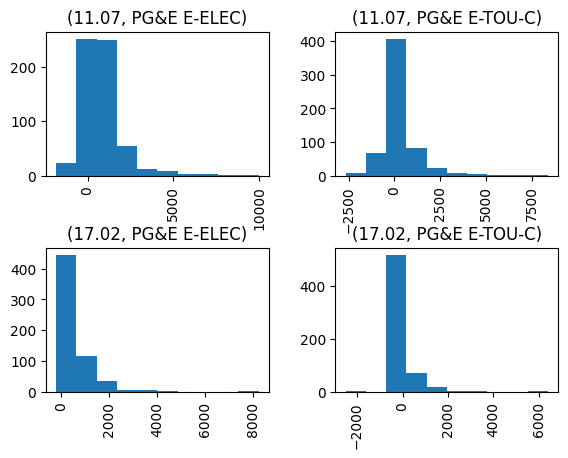

In [0]:
savings_by_building_upgrade_electric_rate.hist("cost_savings", by=["upgrade_id", "rate_name"])

In [0]:
# Savings metrics by upgrade and electric rate
savings_by_building_upgrade_electric_rate.groupby(['upgrade_id', 'rate_name', 'rate_name_baseline']).agg(
    {
        "cost": ["mean", "median"],
        "cost_baseline": ["mean", "median"],
        "cost_savings": ["mean", "median"],
        "has_positive_savings": ["mean"],
    }
)

cost  ... has_positive_savings
                                                   mean  ...                 mean
upgrade_id rate_name    rate_name_baseline               ...                     
11.07      PG&E E-ELEC  PG&E E-TOU-C        4324.566194  ...             0.839607
           PG&E E-TOU-C PG&E E-TOU-C        4791.423666  ...             0.733224
17.02      PG&E E-ELEC  PG&E E-TOU-C        4679.239192  ...             0.826514
           PG&E E-TOU-C PG&E E-TOU-C        5082.527532  ...             0.494272

[4 rows x 7 columns]

In [0]:
# HP Savings metrics by electric rate broken down by cooling type 
building_metadata = filtered_building_id_metadata.toPandas()
building_metadata["building_id"] = building_metadata["building_id"].astype(int)
savings_by_building_upgrade_electric_rate_w_metadata = savings_by_building_upgrade_electric_rate.merge(building_metadata, on="building_id")

savings_by_building_upgrade_electric_rate_w_metadata[savings_by_building_upgrade_electric_rate_w_metadata.upgrade_id==HP_UPGRADE_ID].groupby(['rate_name', 'rate_name_baseline', 'in_hvac_cooling_type']).agg(
    {
        "cost_savings": ["mean", "median"],
        "has_positive_savings": "mean",
        "building_id": "count",
    }
)

cost_savings  ... building_id
                                                             mean  ...       count
rate_name    rate_name_baseline in_hvac_cooling_type               ...            
PG&E E-ELEC  PG&E E-TOU-C       AC                    1062.609245  ...         415
                                None                   215.748611  ...         134
                                Room AC                843.842489  ...          62
PG&E E-TOU-C PG&E E-TOU-C       AC                     603.921538  ...         415
                                None                  -263.928070  ...         134
                                Room AC                350.006332  ...          62

[6 rows x 4 columns]

In [0]:
# HP Savings metrics by electric rate broken down by heating type
savings_by_building_upgrade_electric_rate_w_metadata[savings_by_building_upgrade_electric_rate_w_metadata.upgrade_id==HP_UPGRADE_ID].groupby(['rate_name', 'rate_name_baseline', 'in_heating_fuel']).agg(
    {
        "cost_savings": ["mean", "median"],
        "has_positive_savings": "mean",
        "building_id": "count",
    }
)

cost_savings  ... building_id
                                                        mean  ...       count
rate_name    rate_name_baseline in_heating_fuel               ...            
PG&E E-ELEC  PG&E E-TOU-C       Electricity      2580.507663  ...          87
                                Natural Gas       567.457935  ...         517
                                Propane           618.780852  ...           7
PG&E E-TOU-C PG&E E-TOU-C       Electricity      2076.088605  ...          87
                                Natural Gas       108.160703  ...         517
                                Propane            60.382456  ...           7

[6 rows x 4 columns]

In [0]:
# HPWH Savings metrics by electric rate broken down by heating type
savings_by_building_upgrade_electric_rate_w_metadata[savings_by_building_upgrade_electric_rate_w_metadata.upgrade_id==HPWH_UPGRADE_ID].groupby(['rate_name', 'rate_name_baseline', 'in_water_heater_fuel']).agg(
    {
        "cost_savings": ["mean", "median"],
        "has_positive_savings": "mean",
        "building_id": "count",
    }
)

cost_savings  ... building_id
                                                             mean  ...       count
rate_name    rate_name_baseline in_water_heater_fuel               ...            
PG&E E-ELEC  PG&E E-TOU-C       Electricity           1543.825628  ...          76
                                Natural Gas            342.601221  ...         524
                                Propane                786.581453  ...          11
PG&E E-TOU-C PG&E E-TOU-C       Electricity            963.580659  ...          76
                                Natural Gas            -26.599935  ...         524
                                Propane                -17.886976  ...          11

[6 rows x 4 columns]